In [1]:
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

# Access the environment variable
together_api = os.environ.get('TOGETHER_API_KEY')

In [2]:
from langchain_openai import ChatOpenAI

TOGETHER_AI_BASE_URL = "https://api.together.xyz/v1"

llm = ChatOpenAI(
    model="meta-llama/Llama-3.3-70B-Instruct-Turbo",
    base_url=TOGETHER_AI_BASE_URL,
    api_key=together_api
)

In [3]:
from langchain_core.messages import HumanMessage, SystemMessage

messages = [
    SystemMessage("You are a helpful assistant AI assistant."),
    HumanMessage("Hello, I am Amir. Who are you?"),
]

response = llm.invoke(messages)
response.pretty_print()

================================== Ai Message ==================================

Hello Amir, I'm an AI assistant, which means I'm a computer program designed to help and communicate with users like you. I don't have a personal name, but I'm here to provide information, answer questions, and assist with tasks to the best of my abilities. It's nice to meet you, Amir! How can I help you today?


In [4]:
from typing import TypedDict, Optional

class MyState(TypedDict):
    user_query: str
    rewritten_query: Optional[str]
    need_internet_search: Optional[bool]
    search_results: Optional[str]
    final_answer: Optional[str]
    bad_state: Optional[bool]

In [5]:
def node_query_rewrite(state: MyState) -> MyState:
    """
    Rewrites the user's query using an LLM for clarity or correctness.
    Sanitizes the rewritten query to ensure compatibility with the search engine.
    """
    print("---Node Query Rewrite---")
    user_query = state["user_query"]
    
    # Prompt to rewrite the query
    rewrite_prompt = f"Please rewrite this query suitable for search engines. Ensure it is clear and concise:\n\n{user_query}"
    
    # Invoke the LLM to rewrite the query
    rewritten = llm.invoke(rewrite_prompt).content
    print("Raw rewritten query from LLM:", rewritten)
    
    # Sanitize the rewritten query
    def sanitize_query(query: str) -> str:
        import re
        # Allow only alphanumeric characters, spaces, and basic punctuation (e.g., single quotes, dashes)
        return re.sub(r'[^a-zA-Z0-9\s\'-]', '', query).strip()
    
    sanitized_query = sanitize_query(rewritten)
    print("Sanitized query:", sanitized_query)
    
    # Update the state with the sanitized query
    state["rewritten_query"] = sanitized_query
    return state

In [6]:
from langchain_core.messages import HumanMessage, SystemMessage
import nest_asyncio
from llama_parse import LlamaParse
from llama_index.core import SimpleDirectoryReader
from langchain_text_splitters import RecursiveCharacterTextSplitter
import lancedb
from lancedb.embeddings import get_registry
from lancedb.pydantic import LanceModel, Vector
import pandas as pd

nest_asyncio.apply()
db = lancedb.connect(".lancedb")
pdf_files = ["../assets/The New Complete Book of Foos.pdf"]
llama_pase_api = os.environ.get("LLAMA_PARSE_API_KEY")

parser = LlamaParse(result_type="text", api_key=llama_pase_api)
file_extractor = {".pdf": parser}
data_for_parse = SimpleDirectoryReader(input_files=pdf_files, file_extractor=file_extractor)
documents =data_for_parse.load_data()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1024,
    chunk_overlap=64,
    length_function=len,
    is_separator_regex=False,
)

documents_list = []
page_number = 0
last_doc = None
for doc in documents:
    if last_doc is None or last_doc != doc.metadata["file_name"]:
        page_number = 1
        last_doc = doc.metadata["file_name"]
    else:
        page_number += 1

    texts = text_splitter.split_text(doc.text)
    for text in texts:
        item = {}
        item["id_"] = doc.id_
        item["text"] = text
        item["metadata_file_name"] = doc.metadata["file_name"]
        item["metadata_creation_date"] = doc.metadata["creation_date"]
        item["metadata_pagenumber"] = page_number
        documents_list.append(item)


embedding_model = get_registry().get("sentence-transformers").create(name="BAAI/bge-small-en-v1.5")

class ChunksOfData(LanceModel):
    id_: str
    text: str = embedding_model.SourceField()  # Store text data for search
    metadata_file_name: str
    metadata_creation_date: str
    metadata_pagenumber: int
    vector: Vector(embedding_model.ndims()) = embedding_model.VectorField()  # type: ignore
    
df = pd.DataFrame(documents_list)

def df_to_dict_batches(df: pd.DataFrame, batch_size: int = 128):
    """
    Yields data from a DataFrame in batches of dictionaries.
    Each batch is a list of dict, suitable for LanceDB ingestion.
    """
    for start_idx in range(0, len(df), batch_size):
        end_idx = start_idx + batch_size
        # Convert the batch of rows to a list of dict
        batch_dicts = df.iloc[start_idx:end_idx].to_dict(orient="records")
        yield batch_dicts

/home/davinci/GitHub/JANJAN/lxms/apps/chatfood/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Started parsing the file under job_id 3beccbb0-39ad-40f9-ab94-91f3c553bc08


In [7]:
# Check if the table already exists in the database
if "embedded_chunks3" in db.table_names():
    tbl = db.open_table("embedded_chunks3")
    print("Table 'embedded_chunks3' loaded successfully.")
else:
    print("Table 'embedded_chunks3' not found. Creating a new one...")
    tbl = db.create_table(
        "embedded_chunks3",
        data=df_to_dict_batches(df, batch_size=10),
        schema=ChunksOfData,
    )
    tbl.create_fts_index("text")
    print("Table 'embedded_chunks3' created successfully.")


Table 'embedded_chunks3' loaded successfully.


In [8]:
def node_search_book(state: MyState) -> MyState:
    """
    search from the book
    """
    print("---Node Search the book---")
    query = state["rewritten_query"]
    
    context_list = tbl.search(query, query_type="hybrid").limit(5).to_list()
    context = ''.join([f"{c['text']}\n\n" for c in context_list])
    
    system_prompt = "Answer user query based on the given context.if context is not related, just write: unrelated"
    user_prompt = f"Question:\n{query}\nContext:\n{context}"

    messages = [
        SystemMessage(system_prompt),
        HumanMessage(user_prompt),
    ]
    
    results = llm.invoke(messages)
    
    if results.content.lower() == "unrelated":
        state["need_internet_search"] = True
    else:
        state["need_internet_search"] = False
        state['search_results'] = results
    
    return state

In [9]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_api = os.environ.get("TAVILY_API_KEY")


def node_search_internet(state: MyState) -> MyState:
    """
    Searches the internet for the rewritten query using a search tool.
    """
    if state.get("need_internet_search", False):
        print("---Node Search Internet---")
        rewritten_query = state["rewritten_query"]
    
        # Use your search tool function
        results = TavilySearchResults(max_results=3, tavily_api_key=tavily_api).invoke(rewritten_query)
        print("Search results:")
        print(results)
        # Save the search results in state
        state["search_  results"] = str(results)
        
    return state

In [10]:
def node_generate_answer(state: MyState) -> MyState:
    """
    Generates a final answer based on the original user query and the search results.
    """
    print("---Node Generate Answer---")
    user_query = state["user_query"]
    search_info = state.get("search_results", "No search results found.")
    # search_info = state["search_results"] or "No search results found."
    # Combine user query with search results to generate answer
    try:
        
        if not state["bad_state"]:
            final_answer = llm.invoke(
                f"User's query: {user_query}\n\nSearch results:\n{search_info}\n\n"
                "Please provide a helpful answer."
            )
            print("Final answer:", final_answer.content)
            state["final_answer"] = final_answer.content
        
        
        else:
            print("sorry i can't give services.")
            state["final_answer"] = "Not related Query!"
    except Exception as e:
        print(f"Error during answer generation: {e}")
        state["final_answer"] = "Sorry, there was an issue generating the answer."
    return state

In [11]:
from typing import Literal
from pydantic import BaseModel, Field

class IsRelated(BaseModel):
    reasoning: str = Field(description="The reasoning behind the decision, whether the query is related to restaurants and foods or not.")
    is_related_flag: bool = Field(description="The decision whether the query is related to restaurants and foods or not.")

def is_related(state: MyState) -> Literal["node_query_rewrite", "node_update_bad_state"]:
    query = state["user_query"]
    llm_with_structured_output = llm.with_structured_output(IsRelated)
    try:
        prompt = (
            f"Analyze the following query and decide whether it is related to restaurants or foods. "
            "Respond in this exact JSON format: "
            '{"reasoning": "<reasoning string>", "is_related_flag": <true|false>}.\n\n'
            f"Query: {query}"
        )
        
        response = llm_with_structured_output.invoke(prompt)
        if response and hasattr(response, 'is_related_flag') and isinstance(response.is_related_flag, bool):
            print("-----Is Related-----")
            print(response)
            if response.is_related_flag:
                return "node_query_rewrite"
            else:
                return "node_update_bad_state"  # A node to update `bad_state`
        else:
            print("Invalid response structure.")
            return "node_update_bad_state"
    except Exception as e:
        print(f"Error invoking LLM: {e}")
        return "node_update_bad_state"

In [12]:
def node_update_bad_state(state: MyState) -> MyState:
    """
    Updates the state to indicate a 'bad state' when the query is not related.
    """
    state["bad_state"] = True
    return state

In [13]:
from langgraph.graph import StateGraph, START, END

# Build the graph
builder = StateGraph(MyState)

# Add nodes
builder.add_node("node_query_rewrite", node_query_rewrite)
builder.add_node("node_search_book", node_search_book)
builder.add_node("node_search_internet", node_search_internet)
builder.add_node("node_generate_answer", node_generate_answer)
builder.add_node("node_update_bad_state", node_update_bad_state)

# Add edges (linear flow)
builder.add_conditional_edges(START, is_related)

builder.add_edge("node_update_bad_state", "node_generate_answer")
builder.add_edge("node_query_rewrite", "node_search_book")
builder.add_edge("node_search_book", "node_search_internet")
builder.add_edge("node_search_internet", "node_generate_answer")
builder.add_edge("node_generate_answer", END)

# Compile the graph
advanced_search_graph = builder.compile()

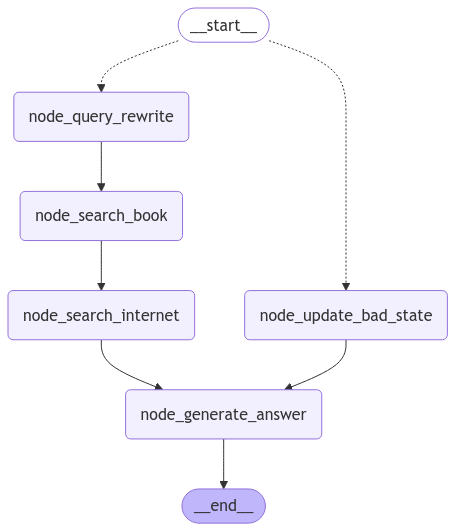

In [14]:
from IPython.display import Image, display

display(Image(advanced_search_graph.get_graph().draw_mermaid_png()))

In [17]:
state = {
    "user_query": "Why is the sky blue?",
    "rewritten_query": None,
    "need_internet_search": None,
    "search_results": None,
    "bad_state": None,
    "final_answer": None,
}

final_state = advanced_search_graph.invoke(state)

print(final_state['final_answer'])

-----Is Related-----
reasoning="The query 'Why is the sky blue?' is a scientific question related to the color of the sky and has no apparent connection to restaurants or food." is_related_flag=False
---Node Generate Answer---
sorry i can't give services.
Not related Query!


# Why Do We Convert Data to Chunks?

### 1. Memory Efficiency:
- Processing large datasets or documents as a whole may exceed memory or hardware limits.
- Splitting data into smaller chunks allows for incremental processing.

### 2. Improved Performance:
- Many machine learning models (e.g., transformers like BERT) have a maximum input size limit (e.g., 512 tokens).
- Chunking ensures the input fits within these constraints.

### 3. Contextual Understanding:
- For models that handle smaller inputs, chunking ensures the text is processed in meaningful segments without truncating important parts.

### 4. Parallel Processing:
- Breaking data into chunks enables parallelization, which speeds up processing tasks like inference or training.

### 5. Handling Long Documents:
- Long documents, which may not fit in a single model input, are divided into chunks to retain as much content as possible.

---

# Effect of chunk_size and chunk_overlap

### 1. Accuracy vs. Efficiency Trade-off:

- Smaller chunk_size with a high chunk_overlap improves context retention but increases processing time and memory usage.
- Larger chunk_size with no overlap processes data faster but risks losing information at boundaries.

### 2. Redundancy:

- High overlap may lead to repetitive information in neighboring chunks. Post-processing may be required to handle this.

---

# What is Hybrid Retrieval?

a method that combines two different types of information retrieval techniques -> to improve search accuracy and relevance

Typically, it blends:

#### 1. Sparse Retrieval (e.g., BM25, TF-IDF):

- Focuses on exact keyword matching.
- Works well when specific terms in the query appear in the document.

#### 2. Dense Retrieval (e.g., Vector Search, Embeddings-based Search):

- Uses vector representations (e.g., embeddings) of the query and documents.
- Finds semantic similarities rather than exact matches.
- Example: If the query is "best restaurants," dense retrieval might match a document that talks about "top-rated dining places," even if the exact words differ.

---

# Why is Hybrid Retrieval Better?

### 1. Advantages of Sparse Retrieval:

- Precision for keyword-based queries: Works well when users know the exact words they are looking for.
- Handling rare terms: Sparse methods excel at retrieving documents with specific rare terms (e.g., product names or technical jargon).

### 2. Advantages of Dense Retrieval:

- Semantic understanding: Captures the meaning of queries and documents even when they use different vocabulary.
- Handling noisy or ambiguous queries: Dense methods are robust when queries are imprecise or when users don't know the exact terminology.

### 3. Combining Both:

Hybrid retrieval bridges gaps between the two methods:

- Sparse retrieval ensures exact matches are considered.
- Dense retrieval ensures semantically relevant documents aren't overlooked.

It improves the recall (finding relevant results) and precision (filtering irrelevant results).

---

# Why do we filter retrieved contexts before generating the answer?

We filter retrieved contexts before generating answers to ensure relevance, accuracy, and efficiency:

1. **Relevance**: Removes unrelated information, focusing only on contexts that match the query.
2. **Accuracy**: Reduces noise and avoids misleading or contradictory data.
3. **Efficiency**: Saves computational resources and prioritizes the most important content.
4. **Intent Alignment**: Ensures the response matches the user's query purpose.

Filtered contexts lead to clearer, more precise answers while optimizing performance.

---

# The model can answer questions. Why didn't we just use the model for answering questions, and why did we implement RAG?


1. **Knowledge Limitations**: Pretrained models have a fixed knowledge cutoff and may lack up-to-date or domain-specific information. RAG enables real-time retrieval of relevant knowledge.

2. **Accuracy**: By grounding responses in retrieved context, RAG ensures answers are factually accurate and backed by external sources.

3. **Contextual Relevance**: RAG retrieves only the most relevant data, aligning the generated response with specific queries.

4. **Scalability**: RAG allows the model to dynamically access vast external knowledge bases, rather than retraining it with every new dataset.

5. **Cost-Efficiency**: Fine-tuning or training a model with extensive domain-specific data is costly. RAG avoids this by combining retrieval with generation.

---

In [16]:
# 